In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets, linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
trainCopy=train.copy()
testCopy=test.copy()


In [3]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
train.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [5]:
train.drop(['employee_id'],axis=1,inplace=True)
test.drop(['employee_id'],axis=1,inplace=True)
train.shape,test.shape

((54808, 13), (23490, 12))

In [6]:
train.is_promoted.value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

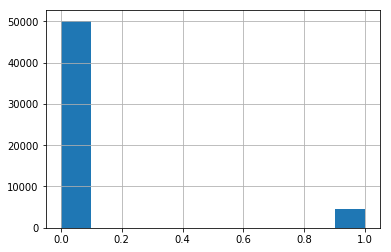

In [7]:
train.is_promoted.hist()

Encoding data 

In [8]:
train['previous_year_rating']=train['previous_year_rating'].fillna(train.previous_year_rating.mode()[0])
train['education'] = train['education'].fillna(train['education'].mode()[0])

test['previous_year_rating']=test['previous_year_rating'].fillna(test.previous_year_rating.mode()[0])
test['education'] = test['education'].fillna(test['education'].mode()[0])

In [9]:

education_mapper = {"Master's & above":3, "Bachelor's":2,"Below Secondary":1}


In [10]:
train['education_scaled'] = train['education'].replace(education_mapper)
test['education_scaled'] = test['education'].replace(education_mapper)
train['education']=train['education_scaled']
train.drop(['education_scaled'],axis=1,inplace=True)
test['education']=test['education_scaled']
test.drop(['education_scaled'],axis=1,inplace=True)

In [11]:
train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,3,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,2,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,2,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,2,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,2,m,other,1,45,3.0,2,0,0,73,0


In [12]:
train['joining_age']=train['age']-train['length_of_service']
test['joining_age']=test['age']-test['length_of_service']

train['training_hours']=train['no_of_trainings']*train['avg_training_score']
test['training_hours']=test['no_of_trainings']*test['avg_training_score']

In [13]:
train.describe()

,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,joining_age,training_hours
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,2.257627,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170,28.938403,79.770636
std,0.469717,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137,5.825101,43.879135
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,17.000000,39.000000
25%,2.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,25.000000,53.000000
50%,2.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,27.000000,64.000000
75%,3.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000,31.000000,84.000000
max,3.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000,58.000000,710.000000


In [15]:
X_selected_oh=train[['education',
  'department','gender',
  'no_of_trainings',
  'age',
  'previous_year_rating',
  'KPIs_met >80%',
  'awards_won?',
  'avg_training_score']]

In [16]:
test_oh=test[['education',
  'department','gender',
  'no_of_trainings',
  'age',
  'previous_year_rating',
  'KPIs_met >80%',
  'awards_won?',
  'avg_training_score']]

In [17]:
ohgender = pd.get_dummies(X_selected_oh['gender'], prefix = 'category')

In [18]:
ohgender_test = pd.get_dummies(test_oh['gender'], prefix = 'category')

In [19]:
oh_department=pd.get_dummies(X_selected_oh['department'], prefix = 'category')

In [20]:
oh_department_test=pd.get_dummies(test_oh['department'], prefix = 'category')

In [21]:
X_selected_oh = pd.concat([X_selected_oh, ohgender,oh_department], axis=1)

In [22]:
test_oh = pd.concat([test_oh, ohgender_test,oh_department_test], axis=1)

In [23]:
X_selected_oh.head()

,education,department,gender,no_of_trainings,age,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,category_f,category_m,category_Analytics,category_Finance,category_HR,category_Legal,category_Operations,category_Procurement,category_R&D,category_Sales & Marketing,category_Technology
0,3,Sales & Marketing,f,1,35,5.0,1,0,49,1,0,0,0,0,0,0,0,0,1,0
1,2,Operations,m,1,30,5.0,0,0,60,0,1,0,0,0,0,1,0,0,0,0
2,2,Sales & Marketing,m,1,34,3.0,0,0,50,0,1,0,0,0,0,0,0,0,1,0
3,2,Sales & Marketing,m,2,39,1.0,0,0,50,0,1,0,0,0,0,0,0,0,1,0
4,2,Technology,m,1,45,3.0,0,0,73,0,1,0,0,0,0,0,0,0,0,1


In [24]:
test_oh.head()

,education,department,gender,no_of_trainings,age,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,category_f,category_m,category_Analytics,category_Finance,category_HR,category_Legal,category_Operations,category_Procurement,category_R&D,category_Sales & Marketing,category_Technology
0,2,Technology,m,1,24,3.0,1,0,77,0,1,0,0,0,0,0,0,0,0,1
1,2,HR,f,1,31,3.0,0,0,51,1,0,0,0,1,0,0,0,0,0,0
2,2,Sales & Marketing,m,1,31,1.0,0,0,47,0,1,0,0,0,0,0,0,0,1,0
3,2,Procurement,f,3,31,2.0,0,0,65,1,0,0,0,0,0,0,1,0,0,0
4,2,Finance,m,1,30,4.0,0,0,61,0,1,0,1,0,0,0,0,0,0,0


In [25]:
X_selected_oh.drop(['department'],axis=1,inplace=True)

In [26]:
X_selected_oh.drop(['gender'],axis=1,inplace=True)

In [27]:
X_selected_oh.head()

,education,no_of_trainings,age,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,category_f,category_m,category_Analytics,category_Finance,category_HR,category_Legal,category_Operations,category_Procurement,category_R&D,category_Sales & Marketing,category_Technology
0,3,1,35,5.0,1,0,49,1,0,0,0,0,0,0,0,0,1,0
1,2,1,30,5.0,0,0,60,0,1,0,0,0,0,1,0,0,0,0
2,2,1,34,3.0,0,0,50,0,1,0,0,0,0,0,0,0,1,0
3,2,2,39,1.0,0,0,50,0,1,0,0,0,0,0,0,0,1,0
4,2,1,45,3.0,0,0,73,0,1,0,0,0,0,0,0,0,0,1


In [28]:
y=trainCopy[['is_promoted']]

In [29]:

import warnings
warnings.filterwarnings("ignore")

In [31]:
scaler = StandardScaler()
scaled_data_oh = scaler.fit_transform(X_selected_oh)

In [32]:
scaled_data_frame_oh=pd.DataFrame(scaled_data_oh)
scaled_data_frame_oh.columns=X_selected_oh.columns
X_selected_scaled_oh=scaled_data_frame_oh
X_selected_scaled_oh.head()

,education,no_of_trainings,age,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,category_f,category_m,category_Analytics,category_Finance,category_HR,category_Legal,category_Operations,category_Procurement,category_R&D,category_Sales & Marketing,category_Technology
0,1.580483,-0.415276,0.025598,1.395766,1.356878,-0.154018,-1.075931,1.536223,-1.536223,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.38696,-0.136256,1.501543,-0.386960
1,-0.548477,-0.415276,-0.627135,1.395766,-0.736986,-0.154018,-0.253282,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,1.956975,-0.38696,-0.136256,-0.665982,-0.386960
2,-0.548477,-0.415276,-0.104948,-0.250651,-0.736986,-0.154018,-1.001145,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.38696,-0.136256,1.501543,-0.386960
3,-0.548477,1.226063,0.547785,-1.897069,-0.736986,-0.154018,-1.001145,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.38696,-0.136256,1.501543,-0.386960
4,-0.548477,-0.415276,1.331064,-0.250651,-0.736986,-0.154018,0.718939,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.38696,-0.136256,-0.665982,2.584249


In [33]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [34]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('RF', RandomForestClassifier()))

In [35]:
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_selected_scaled_oh,y, test_size=0.33, random_state=33)

In [36]:
X_train_oh.head()

,education,no_of_trainings,age,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,category_f,category_m,category_Analytics,category_Finance,category_HR,category_Legal,category_Operations,category_Procurement,category_R&D,category_Sales & Marketing,category_Technology
7625,1.580483,-0.415276,-0.235495,-1.897069,-0.736986,-0.154018,1.092871,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.386960,-0.136256,-0.665982,2.584249
43738,-0.548477,-0.415276,-0.888228,0.572557,1.356878,-0.154018,1.018084,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.386960,-0.136256,-0.665982,2.584249
41040,-0.548477,-0.415276,-0.627135,0.572557,-0.736986,-0.154018,-0.851573,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.386960,-0.136256,1.501543,-0.386960
31856,1.580483,-0.415276,0.417238,-1.897069,-0.736986,-0.154018,0.569367,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,2.584249,-0.136256,-0.665982,-0.386960
10693,-0.548477,-0.415276,0.025598,1.395766,-0.736986,-0.154018,-0.702000,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.386960,-0.136256,1.501543,-0.386960


In [37]:
auc_score=[]
f1_score=[]
names=[]
for name, model in models:
    model.fit(X_train_oh,y_train_oh)
    y_pred_oh=model.predict(X_test_oh)
    names.append(name)
    auc=metrics.roc_auc_score(y_test_oh, y_pred_oh)
    f1=metrics.f1_score(y_test_oh, y_pred_oh)
    auc_score.append(auc)
    f1_score.append(f1)
    print(name,auc,f1)

LR 0.6264932730180612 0.39552964042759964
LDA 0.6414680879828056 0.4281030444964872
KNN 0.6382438461672724 0.40896860986547084
CART 0.6930813533517325 0.45223140495867775
NB 0.5890459297143149 0.2747899159663865
XGB 0.6424639414354344 0.4420537897310514
LGBM 0.671578784553158 0.5060240963855421
RF 0.6850970334648099 0.47944679216288905


From above we can observe that the Highest f1 score is obtained using the LGBM classifier thus we will tune the model based on f1 score for improvement

num_leaves = 2: 
 the auc value is  0.5594424425692746
 the f1 score is  0.21206993795826284
num_leaves = 3: 
 the auc value is  0.623060636215158
 the f1 score is  0.39329268292682923
num_leaves = 4: 
 the auc value is  0.652385826157229
 the f1 score is  0.4648229015041242
num_leaves = 5: 
 the auc value is  0.6595733585095747
 the f1 score is  0.48061273336524646
num_leaves = 6: 
 the auc value is  0.6640404931617764
 the f1 score is  0.49072753209700426
num_leaves = 9: 
 the auc value is  0.6709997434990134
 the f1 score is  0.5058768218147626
num_leaves = 18: 
 the auc value is  0.6732497284334434
 the f1 score is  0.509090909090909
num_leaves = 21: 
 the auc value is  0.6747846009787212
 the f1 score is  0.5120817843866171
num_leaves = 27: 
 the auc value is  0.6749826166500044
 the f1 score is  0.5118219749652295
num_leaves = 31: 
 the auc value is  0.6754832957595442
 the f1 score is  0.5139405204460965
num_leaves = 61: 
 the auc value is  0.6749687679145078
 the f1 score is  0

Text(0, 0.5, 'scores ')

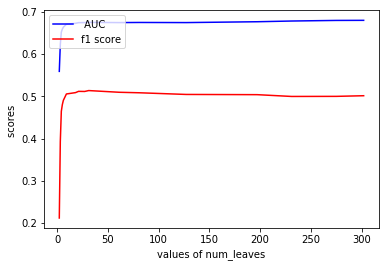

In [38]:
#num_leaves

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled_oh,y, test_size=0.33, random_state=225)

auc=[]
f1=[]
num_leaves= [2,3,4,5,6,9,18,21,27, 31, 61, 81, 127, 197, 231, 275, 302]
for i in num_leaves:
    print('num_leaves = {}: '.format(i))
    clf_lgb = LGBMClassifier(num_leaves=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))

    
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(num_leaves, auc, color="blue", label=" AUC")
line2 = plt.plot(num_leaves, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of num_leaves')
plt.ylabel("scores ")


learning_rate = 0.001: 
 the auc value is  0.5
 the f1 score is  0.0
learning_rate = 0.005: 
 the auc value is  0.5
 the f1 score is  0.0
learning_rate = 0.01: 
 the auc value is  0.6308237940876882
 the f1 score is  0.4142194744976816
learning_rate = 0.05: 
 the auc value is  0.6674674660688338
 the f1 score is  0.4963994239078253
learning_rate = 0.1: 
 the auc value is  0.6707484496593895
 the f1 score is  0.5019011406844106
learning_rate = 0.3: 
 the auc value is  0.6767968837327195
 the f1 score is  0.5085529357374017
learning_rate = 0.5: 
 the auc value is  0.6771240532256059
 the f1 score is  0.49339207048458145


Text(0, 0.5, 'scores ')

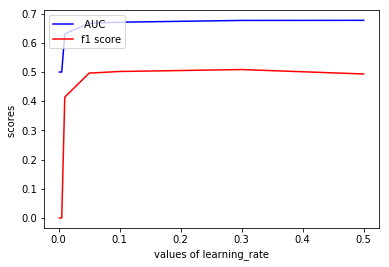

In [39]:
#learning_rate

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled_oh,y, test_size=0.33, random_state=12)

auc=[]
f1=[]
learning_rate=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]
for i in learning_rate:
    print('learning_rate = {}: '.format(i))
    clf_lgb = LGBMClassifier(learning_rate=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(learning_rate, auc, color="blue", label=" AUC")
line2 = plt.plot(learning_rate, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of learning_rate')
plt.ylabel("scores ")

max_bin = 3: 
 the auc value is  0.56609101235392
 the f1 score is  0.23136818687430477
max_bin = 5: 
 the auc value is  0.6182319307978961
 the f1 score is  0.37480954799390553
max_bin = 10: 
 the auc value is  0.6552577564261007
 the f1 score is  0.4663111972855066
max_bin = 12: 
 the auc value is  0.6629006522529727
 the f1 score is  0.48438250840941854
max_bin = 18: 
 the auc value is  0.6642705527383447
 the f1 score is  0.48961854176726216
max_bin = 20: 
 the auc value is  0.6677931989678565
 the f1 score is  0.4971209213051823
max_bin = 22: 
 the auc value is  0.668323833446424
 the f1 score is  0.4976076555023923
max_bin = 24: 
 the auc value is  0.6666110986912432
 the f1 score is  0.49518304431599236
max_bin = 26: 
 the auc value is  0.6715207467769131
 the f1 score is  0.5042816365366317
max_bin = 28: 
 the auc value is  0.6705435480798447
 the f1 score is  0.5021438780371607


Text(0, 0.5, 'scores ')

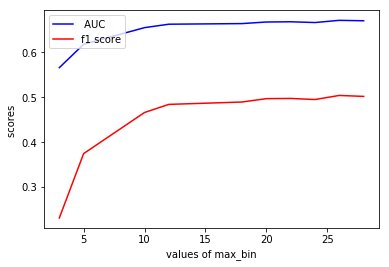

In [40]:
#max_bin': choice([3, 5, 10, 12, 18, 20, 22,24,26,28]),

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled_oh,y, test_size=0.33, random_state=12)

auc=[]
f1=[]
max_bin=[3, 5, 10, 12, 18, 20, 22,24,26,28]
for i in max_bin:
    print('max_bin = {}: '.format(i))
    clf_lgb = LGBMClassifier(max_bin=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(max_bin, auc, color="blue", label=" AUC")
line2 = plt.plot(max_bin, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of max_bin')
plt.ylabel("scores ")

max_depth = 2: 
 the auc value is  0.6221160296553999
 the f1 score is  0.391237901171676
max_depth = 3: 
 the auc value is  0.6511338867982569
 the f1 score is  0.4625121713729309
max_depth = 4: 
 the auc value is  0.6639354528057364
 the f1 score is  0.49049429657794674
max_depth = 5: 
 the auc value is  0.670420004144887
 the f1 score is  0.5037523452157598
max_depth = 6: 
 the auc value is  0.6730012927290899
 the f1 score is  0.5095839177185602
max_depth = 7: 
 the auc value is  0.6738065845019526
 the f1 score is  0.5104797391709361
max_depth = 9: 
 the auc value is  0.6734574387748925
 the f1 score is  0.5095482068001863
max_depth = 11: 
 the auc value is  0.6730780248717926
 the f1 score is  0.5083798882681565


Text(0, 0.5, 'scores ')

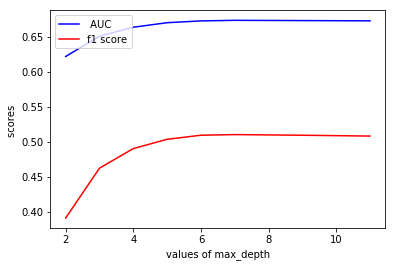

In [41]:
#max_depth': choice([3, 4, 5, 6, 7, 9, 11]),



X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled_oh,y, test_size=0.33, random_state=100)

auc=[]
f1=[]
max_depth=[2,3, 4, 5, 6, 7, 9, 11]
for i in max_depth:
    print('max_depth = {}: '.format(i))
    clf_lgb = LGBMClassifier(max_depth=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(max_depth, auc, color="blue", label=" AUC")
line2 = plt.plot(max_depth, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of max_depth')
plt.ylabel("scores ")


feature_fraction = 0.2: 
 the auc value is  0.5676238950121255
 the f1 score is  0.23752151462994836
feature_fraction = 0.3: 
 the auc value is  0.6153224852813978
 the f1 score is  0.3726839597670726
feature_fraction = 0.4: 
 the auc value is  0.6650837937548814
 the f1 score is  0.4917073170731708
feature_fraction = 0.5: 
 the auc value is  0.6701117885823509
 the f1 score is  0.5033947623666344
feature_fraction = 0.7: 
 the auc value is  0.6710087443802929
 the f1 score is  0.5048355899419729
feature_fraction = 0.8: 
 the auc value is  0.6711898163262128
 the f1 score is  0.5063045586808923
feature_fraction = 0.9: 
 the auc value is  0.6681368050405471
 the f1 score is  0.4990272373540856


Text(0, 0.5, 'scores ')

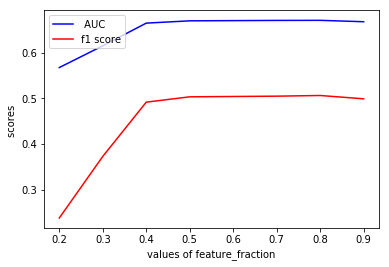

In [42]:
#'feature_fraction': choice([0.5, 0.7, 0.8, 0.9]),

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled_oh,y, test_size=0.33, random_state=200)

auc=[]
f1=[]
feature_fraction=[0.2,0.3,0.4,0.5, 0.7, 0.8, 0.9]
for i in feature_fraction:
    print('feature_fraction = {}: '.format(i))
    clf_lgb = LGBMClassifier(feature_fraction=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(feature_fraction, auc, color="blue", label=" AUC")
line2 = plt.plot(feature_fraction, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of feature_fraction')
plt.ylabel("scores ")

lambda_l1 = 0: 
 the auc value is  0.6696776752921966
 the f1 score is  0.5009727626459144
lambda_l1 = 2: 
 the auc value is  0.6704304274485792
 the f1 score is  0.5012094823415578
lambda_l1 = 5: 
 the auc value is  0.6683518745171629
 the f1 score is  0.49612403100775193
lambda_l1 = 7: 
 the auc value is  0.667538801453554
 the f1 score is  0.49537712895377123
lambda_l1 = 10: 
 the auc value is  0.6629301282424886
 the f1 score is  0.4852941176470589
lambda_l1 = 20: 
 the auc value is  0.65027910711626
 the f1 score is  0.45783132530120485
lambda_l1 = 30: 
 the auc value is  0.6359114585019741
 the f1 score is  0.42612752721617414
lambda_l1 = 40: 
 the auc value is  0.6267544329870697
 the f1 score is  0.4037954665260938


Text(0, 0.5, 'scores ')

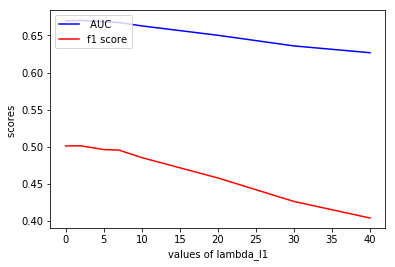

In [43]:
#lambda_l1': choice([0, 10, 20, 30, 40]),

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled_oh,y, test_size=0.33, random_state=250)

auc=[]
f1=[]
lambda_l1=[0,2,5,7, 10, 20, 30, 40]
for i in lambda_l1:
    print('lambda_l1 = {}: '.format(i))
    clf_lgb = LGBMClassifier(lambda_l1=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(lambda_l1, auc, color="blue", label=" AUC")
line2 = plt.plot(lambda_l1, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of lambda_l1')
plt.ylabel("scores ")

scale_pos_weight = 1: 
 the auc value is  0.6742711235869833
 the f1 score is  0.5104364326375712
scale_pos_weight = 2: 
 the auc value is  0.6853040933429353
 the f1 score is  0.5277650298301974
scale_pos_weight = 3: 
 the auc value is  0.7009803994927282
 the f1 score is  0.5240816326530612
scale_pos_weight = 4: 
 the auc value is  0.7263451734309083
 the f1 score is  0.5090664875755541
scale_pos_weight = 5: 
 the auc value is  0.7480206205802056
 the f1 score is  0.4672798948751642
scale_pos_weight = 6: 
 the auc value is  0.7803005611700742
 the f1 score is  0.43488794669897035
scale_pos_weight = 7: 
 the auc value is  0.8004291812534367
 the f1 score is  0.41382851275029947
scale_pos_weight = 8: 
 the auc value is  0.8111461103447809
 the f1 score is  0.3979121891311022
scale_pos_weight = 9: 
 the auc value is  0.811217096425523
 the f1 score is  0.3874084919472913
scale_pos_weight = 10: 
 the auc value is  0.8172962813690543
 the f1 score is  0.38499646142958244
scale_pos_weight 

Text(0, 0.5, 'scores ')

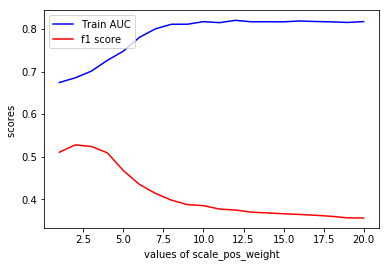

In [44]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled_oh,y, test_size=0.33, random_state=300)

auc=[]
f1=[]
scale_pos_weight = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in scale_pos_weight:
    print('scale_pos_weight = {}: '.format(i))
    clf_lgb = LGBMClassifier(scale_pos_weight=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))

line1 = plt.plot(scale_pos_weight, auc, color="blue", label="Train AUC")
line2 = plt.plot(scale_pos_weight, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of scale_pos_weight')
plt.ylabel("scores ")

params for one hot encoded =
num leaves =9
learning rate =0.1
max bin =26
max_depth =7
feature_fraction =0.7
lambda_l1 =2
scale_pos_weight=3

In [45]:
Model_final_oh=LGBMClassifier(num_leaves=9, earning_rate=0.1, is_unbalance=False, max_bin=20, max_depth=7, feature_fraction=0.7, lambda_l1=2, scale_pos_weight=3)

In [46]:
X_train_final_oh, X_test_final_oh, y_train_final_oh, y_test_final_oh = train_test_split(X_selected_scaled_oh,y, test_size=0.33, random_state=50)


In [47]:
Model_final_oh.fit(X_train_final_oh, y_train_final_oh)
predict_final_oh = Model_final_oh.predict(X_test_final_oh)
print(metrics.roc_auc_score(y_test_final_oh, predict_final_oh))
print(metrics.f1_score(y_test_final_oh, predict_final_oh))

0.6867438793229668
0.4890688259109312


In [48]:
test_oh.head()

,education,department,gender,no_of_trainings,age,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,category_f,category_m,category_Analytics,category_Finance,category_HR,category_Legal,category_Operations,category_Procurement,category_R&D,category_Sales & Marketing,category_Technology
0,2,Technology,m,1,24,3.0,1,0,77,0,1,0,0,0,0,0,0,0,0,1
1,2,HR,f,1,31,3.0,0,0,51,1,0,0,0,1,0,0,0,0,0,0
2,2,Sales & Marketing,m,1,31,1.0,0,0,47,0,1,0,0,0,0,0,0,0,1,0
3,2,Procurement,f,3,31,2.0,0,0,65,1,0,0,0,0,0,0,1,0,0,0
4,2,Finance,m,1,30,4.0,0,0,61,0,1,0,1,0,0,0,0,0,0,0


In [49]:
X_train_final_oh.head()

,education,no_of_trainings,age,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,category_f,category_m,category_Analytics,category_Finance,category_HR,category_Legal,category_Operations,category_Procurement,category_R&D,category_Sales & Marketing,category_Technology
7513,1.580483,-0.415276,0.939424,1.395766,1.356878,-0.154018,-1.001145,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.386960,-0.136256,1.501543,-0.38696
41878,1.580483,-0.415276,1.983797,0.572557,1.356878,-0.154018,-0.627214,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.386960,-0.136256,1.501543,-0.38696
50454,1.580483,-0.415276,1.592157,-1.073860,-0.736986,-0.154018,0.419794,1.536223,-1.536223,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,2.584249,-0.136256,-0.665982,-0.38696
51713,-0.548477,-0.415276,-1.018775,-1.073860,-0.736986,-0.154018,-1.075931,1.536223,-1.536223,-0.328964,-0.220262,-0.214834,-0.139009,-0.510993,-0.386960,-0.136256,1.501543,-0.38696
20783,1.580483,-0.415276,0.808878,1.395766,1.356878,-0.154018,-0.253282,-0.650947,0.650947,-0.328964,-0.220262,-0.214834,7.193797,-0.510993,-0.386960,-0.136256,-0.665982,-0.38696


In [50]:
scaler = StandardScaler()
cols=list(X_train_final_oh.columns)
test_selected_oh=test_oh[cols]
scaled_test_oh = scaler.fit_transform(test_selected_oh)
test_scaled_oh=pd.DataFrame(scaled_test_oh)
test_scaled_oh.columns=cols 
pred_test_oh=Model_final_oh.predict(test_scaled_oh)
# for submissions                          
ids=testCopy['employee_id']
submission = pd.DataFrame({'employee_id': ids,
                           'is_promoted':pred_test_oh
                           })

submission.to_csv("Model_final_oh.csv")